In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from geopy.distance import vincenty
from geopy.distance import great_circle
from sklearn import linear_model
from scipy.spatial import distance
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [96]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')  # train set
df_mess_test = pd.read_csv('mess_test_list.csv')  # test set
# position associated to train set
pos_train = pd.read_csv('pos_train_list.csv')

In [97]:
df_mess_train.head()

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [98]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [99]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [100]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


In [114]:
#On verifie la coherence des données entre objid et coord gps cible
df_trainfeatpos = pd.concat([df_mess_train,pos_train],axis=1)
df_trainfeatpos.drop_duplicates(keep='last', inplace=True)
len(df_trainfeatpos.objid) 

39250

In [115]:
# On regarde les coordonnées cibles différentes
latlist = list(df_trainfeatpos['lat'])
lnglist = list(df_trainfeatpos['lng'])
coordlist = list(zip(latlist,lnglist))
df_trainfeatpos['GPScoord']=coordlist
df_trainfeatpos.head()
len(np.unique(df_trainfeatpos['GPScoord']))

6004

In [116]:
df_trainfeatpos.head()

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,GPScoord
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490,"(39.606689521599996, -104.958489931)"
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490,"(39.606689521599996, -104.958489931)"
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554,"(39.6377412341, -104.958554156)"
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940,"(39.7304174328, -104.96894015299999)"
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940,"(39.7304174328, -104.96894015299999)"


In [117]:
# Distance Base - objet en miles


df_trainfeatpos['DistFromBsid'] = df_trainfeatpos.apply(lambda x:vincenty(x[10],(x[6], x[7])).miles ,axis=1)
                                                        

In [118]:
df_trainfeatpos.head()

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,GPScoord,DistFromBsid
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490,"(39.606689521599996, -104.958489931)",0.789438
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490,"(39.606689521599996, -104.958489931)",4.877716
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554,"(39.6377412341, -104.958554156)",3.188615
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940,"(39.7304174328, -104.96894015299999)",7.258708
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940,"(39.7304174328, -104.96894015299999)",0.843115


/home/joseph/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/joseph/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/joseph/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


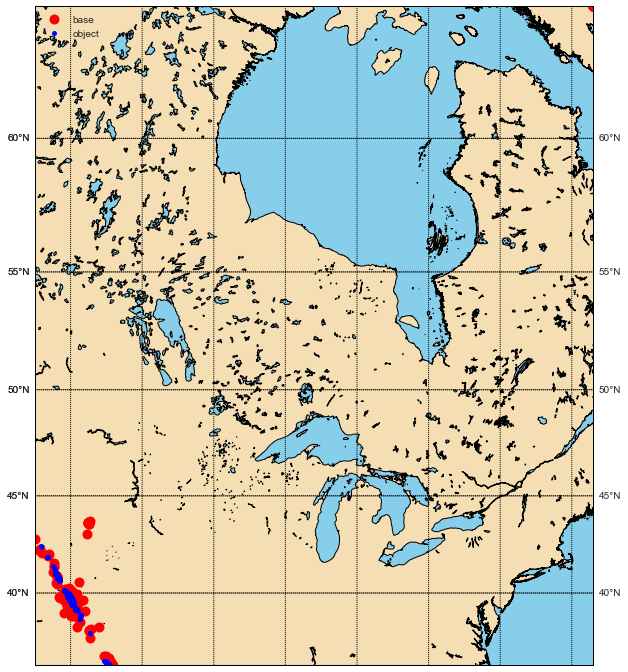

In [205]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

lng_bs = np.array(df_trainfeatpos.groupby('bsid').first().bs_lng)
lat_bs = np.array(df_trainfeatpos.groupby('bsid').first().bs_lat)

lng_obj = np.array(df_trainfeatpos.groupby('objid').first().lng)
lat_obj = np.array(df_trainfeatpos.groupby('objid').first().lat)

plt.figure(figsize=(10,20))

m = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=np.min(lng_bs), llcrnrlat=np.min(lat_bs),
    urcrnrlon=np.max(lng_bs), urcrnrlat=np.max(lat_bs))

m.drawcoastlines()
m.drawparallels(np.arange(10,90,5),labels=[1,1,1,1])
m.drawparallels(range(30, 70, 5),labels=[1,0,0,1])
m.drawmeridians(np.arange(-110,-60,5),labels=[1,0,0,0])
m.fillcontinents(color='wheat',lake_color='skyblue')
m.drawmapboundary(fill_color='skyblue')
#m.fillcontinents()

x,y = m(lng_bs, lat_bs)
m.plot(x, y, 'bo', markersize=10,color='r', label='base')
x,y = m(lng_obj, lat_obj)
m.plot(x, y, 'bo', markersize=5,color='b', label='object')
plt.legend()
plt.show()

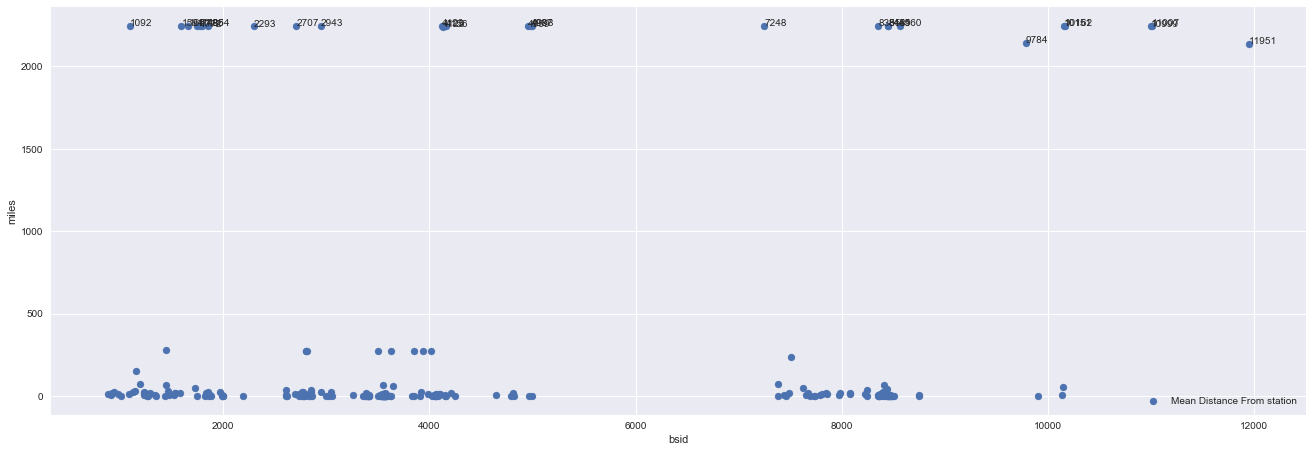

In [107]:
# Distance moyenne des objets par rapport au bsid
plt.style.use('seaborn')
plt.figure(figsize=(22.5, 7.5))
gr_df= df_trainfeatpos.groupby(['bsid'])['DistFromBsid'].mean()

plt.scatter(gr_df.keys(),gr_df.values, label='Mean Distance From station')
plt.xlabel('bsid')
plt.ylabel('miles')
for i, key in enumerate(gr_df.keys()):
    if gr_df[key]>1500:
        plt.annotate(key, (key,gr_df[key]))
plt.legend()
plt.show()




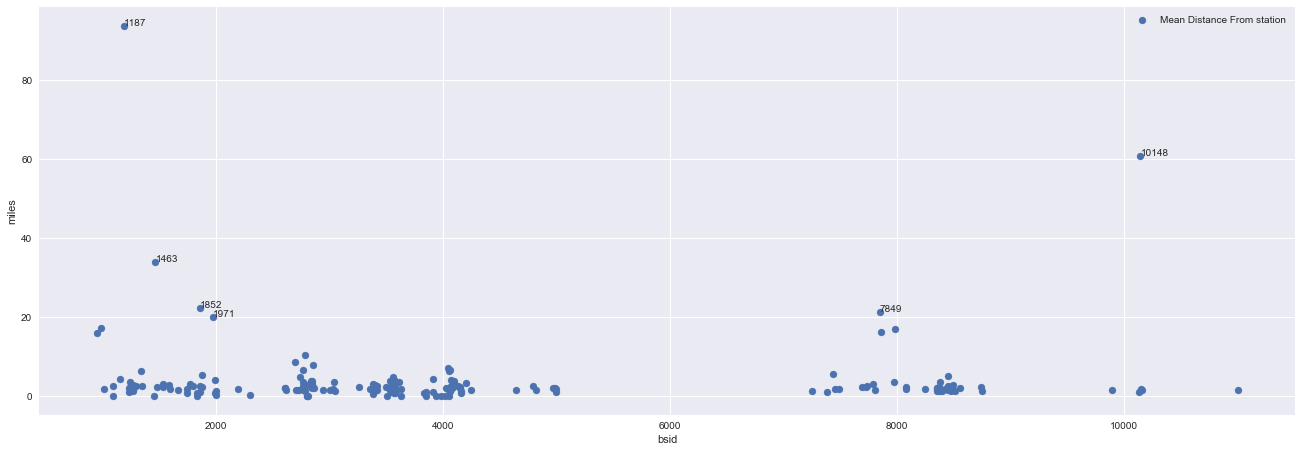

In [108]:
#Ecart type des distance objets bsid par bsid
plt.style.use('seaborn')
plt.figure(figsize=(22.5, 7.5))
gr_dfstd= df_trainfeatpos.groupby(['bsid'])['DistFromBsid'].std()
plt.scatter(gr_dfstd.keys(),gr_dfstd.values, label='Mean Distance From station')
plt.xlabel('bsid')
plt.ylabel('miles')
for i, key in enumerate(gr_dfstd.keys()):
    if gr_dfstd[key]>20:
        plt.annotate(key, (key,gr_dfstd[key]))
plt.legend()
plt.show()



In [109]:
#
gr_df_sort = gr_df.sort_values(ascending=False)
gr_dfstd_sort = gr_dfstd.sort_values(ascending=False)

gr_df_sort = gr_df_sort[gr_df_sort.values > 2000]
gr_dfstd_sort = gr_dfstd_sort[gr_dfstd_sort.values > 20]

print('Nous avons ', len(gr_df_sort), ' bases qui recoivent des signaux provenant de devices très éloignés')
print('Nous avons ', len(gr_dfstd_sort), ' bases qui recoivent des signaux provenant de devices ayant une variance de distance sup à 20 miles')

#Est ce les bases les plus éloignées qui recoivent les signaux ayant une distance la plus variable

bsid_outliers = [x for x in gr_df_sort.keys() if x in gr_dfstd_sort.keys()]
print(bsid_outliers)
print('Les bsid outliers ayant un ecart type sup à 20 miles sont:', gr_dfstd_sort.keys() )

Nous avons  27  bases qui recoivent des signaux provenant de devices très éloignés
Nous avons  6  bases qui recoivent des signaux provenant de devices ayant une variance de distance sup à 20 miles
[]
Les bsid outliers ayant un ecart type sup à 20 miles sont: Int64Index([1187, 10148, 1463, 1852, 7849, 1971], dtype='int64', name='bsid')


/home/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


In [110]:
#Check how many messages are concerned bsid outliers
df_outlier = df_trainfeatpos[df_trainfeatpos['bsid'].isin(gr_dfstd_sort.keys()) ]
objidtocheck = df_outlier.groupby('objid')['bsid'].count()
print(objidtocheck)

df_outliertest = df_mess_test[df_mess_test['bsid'].isin(gr_dfstd_sort.keys()) ]
objidtochecktest = df_outliertest.groupby('objid')['bsid'].count()
print("No Objid concerned in the test set",len(objidtochecktest))


objid
576b81a5cf554f6d991dc3fe    1
576b867ecf554f6d9920f425    1
57754772cf554f3ea39d1745    1
5777eff8e541cd317b71e573    1
57aeb41fe541cd77a044cdb8    4
57aed427e541cd77a05a9b32    1
57d82476e541cd01b39e56af    1
582ec2d812f1434b9cacc01f    1
58302f58e541cd03e7edeb7b    1
58332792cf554f7e3a609f56    1
5835da9ce541cd03e70b29a7    1
583da24412f1434b9ca36825    1
58463bbd12f14360d7d6b125    1
5847bd31e541cd0e13a086f8    1
Name: bsid, dtype: int64
No Objid concerned in the test set 0


In [111]:
#check if this message are received by other bsid

dfcheck = df_trainfeatpos[df_trainfeatpos['objid'].isin(objidtocheck.keys())]
check =dfcheck['objid'].value_counts()
check

57aeb41fe541cd77a044cdb8    106
583da24412f1434b9ca36825      7
57aed427e541cd77a05a9b32      5
5777eff8e541cd317b71e573      4
5835da9ce541cd03e70b29a7      3
58302f58e541cd03e7edeb7b      3
57d82476e541cd01b39e56af      1
582ec2d812f1434b9cacc01f      1
58463bbd12f14360d7d6b125      1
5847bd31e541cd0e13a086f8      1
57754772cf554f3ea39d1745      1
576b867ecf554f6d9920f425      1
576b81a5cf554f6d991dc3fe      1
58332792cf554f7e3a609f56      1
Name: objid, dtype: int64

In [112]:
# On va effacer completement les messages suivants ceux qui ont ete recus seulement par les outliers
ObjidToRemove = [x for x in objidtocheck.keys() if objidtocheck[x]>=check[x]]
ObjidToRemove


['576b81a5cf554f6d991dc3fe',
 '576b867ecf554f6d9920f425',
 '57754772cf554f3ea39d1745',
 '57d82476e541cd01b39e56af',
 '582ec2d812f1434b9cacc01f',
 '58332792cf554f7e3a609f56',
 '58463bbd12f14360d7d6b125',
 '5847bd31e541cd0e13a086f8']

In [119]:
indexToRemove = df_trainfeatpos[df_trainfeatpos['bsid'].isin(gr_dfstd_sort.keys())].index
df_trainfeatposcleaned = df_trainfeatpos.drop(indexToRemove,axis=0)
df_trainfeatposcleaned.drop(['GPScoord','DistFromBsid','nseq','did'],axis=1,inplace=True)
df_trainfeatposcleaned.head()

,objid,bsid,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,573bf1d9864fce1a9af8c5c9,2841,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,3526,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490
2,573bf3533e952e19126b256a,2605,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,2610,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,3574,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940


### Duplicates in coord then primary key is (objid, nseq, time_ux, lat, lng)

In [120]:
listOfBs = np.union1d(np.unique(df_trainfeatposcleaned['bsid']), np.unique(df_mess_test[
                      'bsid']))  # determine all Base stations that received at least 1 message
len(listOfBs)

253

In [121]:
#Nombres maximum de bases qui ont captés un message
MaxDim = np.max(df_trainfeatposcleaned.groupby('objid')['bsid'].count())
print(MaxDim)

102


In [199]:

# Construction Matrice bsid coordonnées


def bsidlnlat_mat_const(df_trainfeatpos , test ):
    # Dataframe with unique bsid and lat lng
    dfbslatbslngfrTr = df_trainfeatpos.loc[:, ['bsid', 'bs_lat', 'bs_lng']]
    dfbslatbslngfrTr.set_index(['bsid'])
    dfbslatbslngfrTr.drop_duplicates(keep='last', inplace=True)
    dfbslatbslngfrTest = df_mess_test.loc[:, ['bsid', 'bs_lat', 'bs_lng']]
    dfbslatbslngfrTest.set_index(['bsid'])
    dfbslatbslngfrTest.drop_duplicates(keep='last', inplace=True)
    dfbslnlat = dfbslatbslngfrTr.merge(dfbslatbslngfrTest,how='outer')
    return dfbslnlat


   


In [123]:
dfbslnlat=bsidlnlat_mat_const(df_trainfeatposcleaned, False)


In [124]:
dfbslnlat.head()

,bsid,bs_lat,bs_lng
0,3515,39.883005,-104.943120
1,2836,39.909932,-104.647094
2,1432,40.073812,-105.440431
3,3907,40.008466,-105.181416
4,1534,36.053394,-102.011461


In [125]:
len(dfbslnlat)

253

In [126]:
# une idée trier les bases par proximité en termes de distance
dfbsordered = dfbslnlat.sort_values(by=['bsid'])
print(len(dfbsordered.loc[:,['bs_lat']]))
dfbsordered['Coord']= list(zip(dfbsordered['bs_lat'],dfbsordered['bs_lng']))
dfbsordered.set_index(['bsid'], inplace=True)
dfbsordered.head()

253


,bs_lat,bs_lng,Coord
bsid,,,
879,39.739013,-105.392793,"(39.739013090300006, -105.392793341)"
911,42.324279,-107.159505,"(42.3242786438, -107.159505381)"
921,42.131222,-107.008741,"(42.1312221478, -107.008741214)"
944,41.424900,-106.143919,"(41.4248995322, -106.14391869100001)"
980,38.997730,-104.684275,"(38.9977304991, -104.68427491899999)"


In [127]:
#Matrice de distance entre toutes les bases
Gpscoordlist = list(dfbsordered['Coord'])
square = pd.DataFrame(
    np.zeros(len(dfbsordered) ** 2).reshape(len(dfbsordered), len(dfbsordered)),
    index=dfbsordered.index, columns=dfbsordered.index)



for col in square.columns:
    for bs in square.index:
        square.loc[bs, col] = vincenty(
            dfbsordered.loc[bs, ['Coord']], dfbsordered.loc[col, ['Coord']]).miles


In [128]:
square.head()

bsid,879,911,921,944,980,1012,1086,1092,1120,1131,...,9899,9936,9941,9949,10134,10151,10162,10999,11007,11951
bsid,,,,,,,,,,,,,,,,,,,,,
879,0.000000,200.857733,185.463872,122.854117,63.674335,14.686734,31.187932,2254.117795,58.170018,14.180798,...,19.828994,638.484737,2254.117795,2254.117795,25.855176,2254.117795,2254.117795,2254.117795,2254.117795,2254.117795
911,200.857733,0.000000,15.406577,81.221759,263.794542,195.873094,200.723880,2146.861357,142.853163,197.300520,...,207.254321,438.004904,2146.861357,2146.861357,199.827831,2146.861357,2146.861357,2146.861357,2146.861357,2146.861357
921,185.463872,15.406577,0.000000,66.122123,248.388037,180.474369,185.430381,2154.140284,127.482974,181.901440,...,191.871129,453.316428,2154.140284,2154.140284,184.488880,2154.140284,2154.140284,2154.140284,2154.140284,2154.140284
944,122.854117,81.221759,66.122123,0.000000,184.400026,116.188167,119.777873,2172.808793,67.019955,117.622016,...,127.105375,516.292062,2172.808793,2172.808793,119.159525,2172.808793,2172.808793,2172.808793,2172.808793,2172.808793
980,63.674335,263.794542,248.388037,184.400026,0.000000,68.212036,68.256887,2280.894049,121.656641,66.778232,...,57.737332,700.688876,2280.894049,2280.894049,67.013836,2280.894049,2280.894049,2280.894049,2280.894049,2280.894049


In [173]:
# Nous allons selectionner les bases ayant reçu le signal
# et leurs plus proches voisins, partant de celle qui a reçu le rssi le
# plus elevé


def feat_mat_const(df, n, listOfBs, dfbslnlat, test):
    i = 0
    grouped_df = df.groupby(['objid'])

    if test:
        df_feat = pd.pivot_table(df, values=[
            'rssi'], index=['objid'], columns='bsid', fill_value=-10**6)
        df_feat.columns = df_feat.columns.get_level_values(1)
        df_feat[df_feat.columns] += 10**6

    else:
        df_feat = pd.pivot_table(df, values=[
            'rssi'], index=['objid', 'lat', 'lng'], columns='bsid', fill_value=-10**6)
        df_feat.columns = df_feat.columns.get_level_values(1)
        df_feat[df_feat.columns] += 10**6
        df_feat.reset_index(inplace=True)
        df_feat.set_index('objid', inplace=True)

    # On rajoute les bases non présentes et on ordonne afin d'avoir
    # le meme espace mulidimensionnel d'apprentissage

    setbs = set(listOfBs)
    columnstoadd = setbs.difference(df_feat.columns)
    bornedfarbsid = dict()
    for col in columnstoadd:
        df_feat[col] = 0
    
    if test:
        cols= sorted(df_feat.columns)
        
    else:
        cols=['lat', 'lng']
        cols.extend(sorted(df_feat.columns[2:]))
    df_feat.reindex(cols,axis=1)
        
    if n > 0:
        ClosestbsidLat = [str(x) + '_lat' for x in range(0, n)]
        ClosestbsidLng = [str(x) + '_lng' for x in range(0, n)]

        for i, c in enumerate(ClosestbsidLat):
            df_feat[ClosestbsidLat[i]] = 0
            df_feat[ClosestbsidLng[i]] = 0

        
        bsiddict = dict()
        for key, item in grouped_df:
            rssi = list(item['rssi'])
            if len(rssi) > 1:
                bsiddict[key] = item.iloc[np.argsort(list(item['rssi']))[-1], 1]
            else:
                bsiddict[key] = int(item['bsid'].values)

            a = square.loc[bsiddict[key], :].T
            a = a.sort_values(ascending=True)
            Closestbsid = list(a.index[0:n])
            Selectecdbsid = set(Closestbsid)
            bsidborned = set(item.loc[:, 'bsid'].values[0:n])
            bsidSelection = set(bsidborned.difference(Selectecdbsid))
            if len(bsidSelection) > 0:
                bornedfarbsid[key] = bsidSelection

            bsidSelection.update(Closestbsid[0:n - len(bsidSelection)])

            df_feat.loc[key, ClosestbsidLat] = dfbslnlat.loc[
                bsidSelection, 'bs_lat'].values
            df_feat.loc[key, ClosestbsidLng] = dfbslnlat.loc[
                bsidSelection, 'bs_lng'].values

    return bornedfarbsid, df_feat

In [174]:
#Nous allons ou limiter au n stations les plus voisines
farbsid=[]
df_feat=[]
Corr={0:0, 1:10, 2:26, 3:52}

#0 stations
farbsid_0, df_feat_0 = feat_mat_const(df_trainfeatposcleaned,0,listOfBs,dfbsordered,False)
#10 Stations
farbsid_10,df_feat_10 = feat_mat_const(df_trainfeatposcleaned,10,listOfBs,dfbsordered,False)
#26 stations
farbsid_26,df_feat_26 = feat_mat_const(df_trainfeatposcleaned,26,listOfBs,dfbsordered,False)
#52 Stations
farbsid_52,df_feat_52 = feat_mat_const(df_trainfeatposcleaned,52,listOfBs,dfbsordered,False)

In [175]:
print(df_feat_0.shape)
print(df_feat_10.shape)
print(df_feat_26.shape)
print(df_feat_52.shape)


(6060, 255)
(6060, 275)
(6060, 307)
(6060, 359)


In [176]:
farbsid=[farbsid_10, farbsid_26, farbsid_52]
df_feat=[df_feat_0,df_feat_10, df_feat_26, df_feat_52]

In [177]:
bsiddistantborned = set(
    [item for sublist in farbsid[0].values() for item in sublist])
bsiddistantborned.update(
    set([item for sublist in farbsid[1].values() for item in sublist]))
bsiddistantborned.update(
    set([item for sublist in farbsid[2].values() for item in sublist]))
len(bsiddistantborned)


238

### Les bases bornées ne sont pas celles en general qui sont la plus proche de celle qui a recu le signal le moins attenué

In [178]:
# ground truth construction

def ground_truth_const(df_feat):
    ground_truth_lat = df_feat['lat'].values.reshape(-1,1)
    ground_truth_lng = df_feat['lng'].values.reshape(-1,1)
    dfinal = df_feat.reset_index()
    dfinal.drop(labels=['lat', 'lng', 'objid'], inplace=True, axis=1)
    sparsedf=csr_matrix(dfinal.values)
    return ground_truth_lat.ravel(), ground_truth_lng.ravel(), sparsedf

In [179]:
ground_truth_lat=[None]*4
ground_truth_lng=[None]*4
dfinal=[None]*4

for i in range(0,4):
    ground_truth_lat[i], ground_truth_lng[i], dfinal[i]=ground_truth_const(df_feat[i])



In [180]:
def regressor_and_predict(ground_truth_lat, ground_truth_lng, df_test,  clflat, clflng):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng
       
    y_pred_lat=clflat.predict(df_test)
    y_pred_lng=clflng.predict(df_test)
    
    
    return y_pred_lat, y_pred_lng

In [181]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [182]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

### Data Analysis

In [183]:

#KNN
clflatKNN = KNeighborsRegressor()
clflngKNN = KNeighborsRegressor()


In [184]:
# Train Test Split
# 26
X_trainlat = [None]*4
X_testlat = [None]*4
y_trainlat = [None]*4
y_testlat = [None]*4
X_trainlng = [None]*4
X_testlng = [None]*4
y_testlng = [None]*4
y_trainlng = [None]*4

for i in range(0, 4):
    X_trainlat[i], X_testlat[i], y_trainlat[i], y_testlat[i] = train_test_split(
        dfinal[i], ground_truth_lat[i], test_size=0.1, random_state=26)
    X_trainlng[i], X_testlng[i], y_trainlng[i], y_testlng[i] = train_test_split(
        dfinal[i], ground_truth_lng[i], test_size=0.1, random_state=26)

### On va rechercher le nombre de bases optimum parmi [0, 10, 26, 52]

In [185]:

# Grid Search KNN
clflat_KNN =[None]*4
clflng_KNN=[None]*4
parameters = {'n_neighbors': [3,5,7],
              'p': [1,2],
              'weights': ['distance']}
for i in range(0,4):
    clflat_KNN[i] = GridSearchCV(clflatKNN, parameters, verbose=1, n_jobs=-1, cv=10)
    clflng_KNN[i] = GridSearchCV(clflngKNN, parameters, verbose=1, n_jobs=-1, cv=10)


In [186]:
for i in range(0,4):
    clflat_KNN[i].fit(X_trainlat[i], y_trainlat[i])
    clflng_KNN[i].fit(X_trainlng[i], y_trainlng[i])


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   25.5s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   24.0s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   49.0s finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.3s


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   52.1s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.6min finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.9min finished


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.7min finished


In [187]:
# Displaying the best estimators

for i in range(0,4):
    print(clflng_KNN[i].best_estimator_, clflng_KNN[i].best_estimator_)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=1,
          weights='distance') KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=1,
          weights='distance')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=1,
          weights='distance') KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=1,
          weights='distance')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=1,
          weights='distance') KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=1,
          weights='distance')
KNeighborsRegressor(algorith

In [188]:
y_pred_lat=[None]*4
y_pred_lng=[None]*4

for i in range(0,4):
    y_pred_lat[i] = clflat_KNN[i].best_estimator_.predict(X_testlat[i])
    y_pred_lng[i] = clflng_KNN[i].best_estimator_.predict(X_testlng[i])
                           
    



In [189]:
err_vec=[None]*4
for i in range(0,4):
    err_vec[i] = Eval_geoloc(y_testlat[i] , y_testlng[i], y_pred_lat[i], y_pred_lng[i])
    print("L'erreur est ",[Corr[i], np.percentile(err_vec[i], 80)])

L'erreur est  [0, 3217.7748713688288]
L'erreur est  [10, 3206.2540781084153]
L'erreur est  [26, 3217.7748713688288]
L'erreur est  [52, 3217.8441304195098]


In [190]:
#le meilleur modele est celui pour les 10 bases les plus proches
#Rendons notre score le plus robuste avec un cross val en leave one out sur le train total
y_pred_lat=[None]*2
y_pred_lng=[None]*2

y_pred_lat[0] = cross_val_predict(clflat_KNN[1].best_estimator_, dfinal[1], ground_truth_lat[1], 
                           cv=(dfinal[1].shape[0] - 1), n_jobs= -1, 
                           verbose=2)
y_pred_lng[0] = cross_val_predict(clflng_KNN[1].best_estimator_, dfinal[1], ground_truth_lng[1], 
                           cv=(dfinal[1].shape[0] - 1), n_jobs= -1, 
                           verbose=2)
y_pred_lat[1] = cross_val_predict(clflat_KNN[3].best_estimator_, dfinal[3], ground_truth_lat[3], 
                           cv=(dfinal[3].shape[0] - 1), n_jobs= -1, 
                           verbose=2)
y_pred_lng[1] = cross_val_predict(clflng_KNN[3].best_estimator_, dfinal[1], ground_truth_lng[3], 
                           cv=(dfinal[3].shape[0] - 1), n_jobs= -1, 
                           verbose=2)



[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 3172 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 6059 out of 6059 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2196 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 6059 out of 6059 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2014 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 3712 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 5902 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 6059 out of 6059 | elapsed:   26.4s finished
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2276 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 6059 out of 6059 | elapsed:    8.1s finished


L'erreur est  [10, 2964.0934995725011]
L'erreur est  [52, 2973.6579951017666]


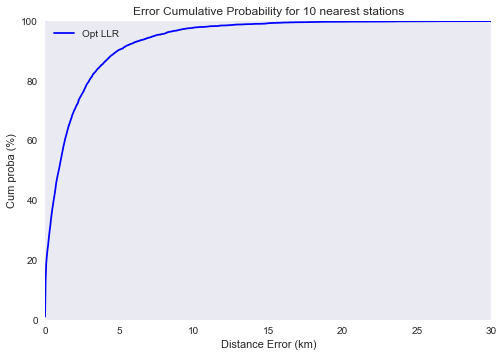

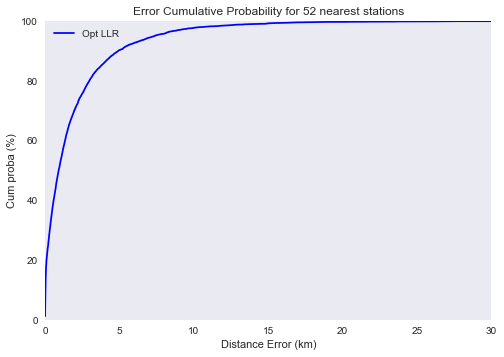

In [191]:
err_vec[0] = Eval_geoloc(ground_truth_lat[1] , ground_truth_lng[1], y_pred_lat[0], y_pred_lng[0])
err_vec[1] = Eval_geoloc(ground_truth_lat[3] , ground_truth_lng[3], y_pred_lat[1], y_pred_lng[1])

print("L'erreur est ",[Corr[1], np.percentile(err_vec[0], 80)])
print("L'erreur est ",[Corr[3], np.percentile(err_vec[1], 80)])

for i in range(0,2):
    values, base = np.histogram(err_vec[i], bins=50000)
    cumulative = np.cumsum(values) 
    plt.figure();
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)');
    plt.axis([0, 30, 0, 100]); 
    if i==0:
        plt.title('Error Cumulative Probability for '+str(Corr[i+1])+' nearest stations'); 
    else:
        plt.title('Error Cumulative Probability for '+str(Corr[i+2])+' nearest stations');
    plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

### Meilleur Modele pour les 10 plus proches voisines

In [63]:
# XgBoost
clflat_Xgb=[None]*4
clflng_Xgb=[None]*4
model_lat=[None]*4
model_lng=[None]*4

# Nos Pc ne sont pas assez puissants pour runnner une grid search!!!
model_lat[0] = xgb.XGBRegressor(max_depth=12,
                   n_estimators=2500,
                   learning_rate=0.01)
model_lng[0] = xgb.XGBRegressor(max_depth=12,
                   n_estimators=2500,
                   learning_rate=0.01)
model_lat[1] = xgb.XGBRegressor(max_depth=12,
                   n_estimators=2500,
                   learning_rate=0.01)
model_lng[1] = xgb.XGBRegressor(max_depth=12,
                   n_estimators=2500,
                   learning_rate=0.01)
model_lat[2] = xgb.XGBRegressor(max_depth=12,
                   n_estimators=2500,
                   learning_rate=0.01)
model_lng[2] = xgb.XGBRegressor(max_depth=12,
                   n_estimators=2500,
                   learning_rate=0.01)
model_lat[3] = xgb.XGBRegressor(max_depth=12,
                   n_estimators=2500,
                   learning_rate=0.01)
model_lng[3] = xgb.XGBRegressor(max_depth=12,
                   n_estimators=2500,
                   learning_rate=0.01)


# Grid Search Xgboost
parameters_Xgb = {'max_depth': [6,10,12],
                  'n_estimators': [1500,2500],
                  'learning_rate': [0.01,0.05],
                  'min_child_weight':[1,3,6]}
clflat_Xgb[0] = GridSearchCV(model_lat[0], parameters_Xgb,
                          verbose=2, n_jobs=-1, cv=5, scoring='r2')
clflat_Xgb[1] = GridSearchCV(model_lat[1], parameters_Xgb,
                          verbose=2, n_jobs=-1, cv=5,scoring='r2')
clflat_Xgb[2] = GridSearchCV(model_lat[2], parameters_Xgb,
                          verbose=2, n_jobs=-1, cv=5,scoring='r2')
clflng_Xgb[0] = GridSearchCV(model_lng[0], parameters_Xgb,
                          verbose=2, n_jobs=-1, cv=5,scoring='r2')
clflng_Xgb[1] = GridSearchCV(model_lng[1], parameters_Xgb,
                          verbose=2, n_jobs=-1, cv=5,scoring='r2')
clflng_Xgb[2] = GridSearchCV(model_lat[2], parameters_Xgb,
                          verbose=2, n_jobs=-1, cv=5,scoring='r2')



In [70]:
model_lat[0].fit(X_trainlat[0], y_trainlat[0])
model_lng[0].fit(X_trainlng[0], y_trainlng[0])

model_lat[1].fit(X_trainlat[1], y_trainlat[1])
model_lng[1].fit(X_trainlng[1], y_trainlng[1])

model_lat[2].fit(X_trainlat[2], y_trainlat[2])
model_lng[2].fit(X_trainlng[2], y_trainlng[2])

model_lat[3].fit(X_trainlat[3], y_trainlat[3])
model_lng[3].fit(X_trainlng[3], y_trainlng[3])



XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=12,
       min_child_weight=1, missing=None, n_estimators=2500, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [74]:
y_pred_lat=[None]*3
y_pred_lng=[None]*3
err_vec=[None]*3

#y_pred_lat[0]=model_lat[0].predict(X_testlat[0])
#y_pred_lng[0]=model_lng[0].predict(X_testlng[0])
y_pred_lat[0]=model_lat[1].predict(X_testlat[1])
y_pred_lng[0]=model_lng[1].predict(X_testlng[1])
y_pred_lat[1]=model_lat[2].predict(X_testlat[2])
y_pred_lng[1]=model_lng[2].predict(X_testlng[2])
y_pred_lat[2]=model_lat[3].predict(X_testlat[3])
y_pred_lng[2]=model_lng[3].predict(X_testlng[3])

err_vec[0] = Eval_geoloc(y_testlat[0] , y_testlng[0], y_pred_lat[0], y_pred_lng[0])
err_vec[1] = Eval_geoloc(y_testlat[1] , y_testlng[1], y_pred_lat[1], y_pred_lng[1])
err_vec[2] = Eval_geoloc(y_testlat[2] , y_testlng[2], y_pred_lat[2], y_pred_lng[2])


print("L'erreur est pour les 10 plus proches ", np.percentile(err_vec[0], 80))
print("L'erreur est pour les 26 plus proches ", np.percentile(err_vec[1], 80))
print("L'erreur est pour les 52 plus proches ", np.percentile(err_vec[2], 80))

L'erreur est pour les 10 plus proches  3266.08132211
L'erreur est pour les 26 plus proches  3174.34219816
L'erreur est pour les 52 plus proches  3368.75441017


In [ ]:
#le meilleur modele est celui pour les 26 bases les plus proches
#Rendons notre score le plus robuste avec un cross val en leave one out sur le train total
#Néanmoins le gain potentiel ne justifie pas le temps de CPU
y_pred_lat=[None]*3
y_pred_lng=[None]*3

y_pred_lat[0] = cross_val_predict(model_lat[2], dfinal[2], ground_truth_lat[2], 
                           cv=10, n_jobs= -1, 
                           verbose=2)
y_pred_lng[0] = cross_val_predict(model_lng[2], dfinal[2], ground_truth_lng[2], 
                           cv=10, n_jobs= -1, 
                           verbose=2)

### Construct test prediction avec KNN 10 plus proches

In [192]:
df_mess_test.head()

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [193]:
a,df_feat_test = feat_mat_const(df_mess_test,10,listOfBs,dfbsordered,True)

In [194]:
df_feat_test.head()

bsid,1012,1086,1092,1131,1264,1268,1292,1334,1344,1432,...,5_lat,5_lng,6_lat,6_lng,7_lat,7_lng,8_lat,8_lng,9_lat,9_lng
objid,,,,,,,,,,,,,,,,,,,,,
573be2503e952e191262c351,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,...,39.757890,-105.119324,39.706436,-105.099323,39.718401,-105.176031,39.734330,-105.165355,39.728651,-105.163032
573c05f83e952e1912758013,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,...,39.770853,-105.071494,39.803795,-105.072090,39.734330,-105.165355,39.779908,-105.062479,39.783211,-105.088747
573c0796f0fe6e735a66deb3,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,...,39.681876,-104.986868,39.665430,-105.111885,39.692976,-105.044371,39.718120,-105.066748,39.666188,-105.077530
573c08d2864fce1a9a0563bc,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,...,39.770853,-105.071494,39.759461,-105.074287,39.803795,-105.072090,39.779908,-105.062479,39.783211,-105.088747
573c08ff864fce1a9a0579b0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,...,39.681876,-104.986868,39.665430,-105.111885,39.692976,-105.044371,39.718120,-105.066748,39.666188,-105.077530


In [195]:
dfinaltest = df_feat_test.reset_index()
testobjid=dfinaltest['objid']
dfinaltest.drop(labels=['objid'], inplace=True, axis=1)
dfinaltest=csr_matrix(dfinaltest.values)

In [196]:
y_pred_lat = clflat_KNN[1].best_estimator_.predict(dfinaltest)
y_pred_lng = clflng_KNN[1].best_estimator_.predict(dfinaltest)
 

/home/joseph/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/joseph/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/joseph/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


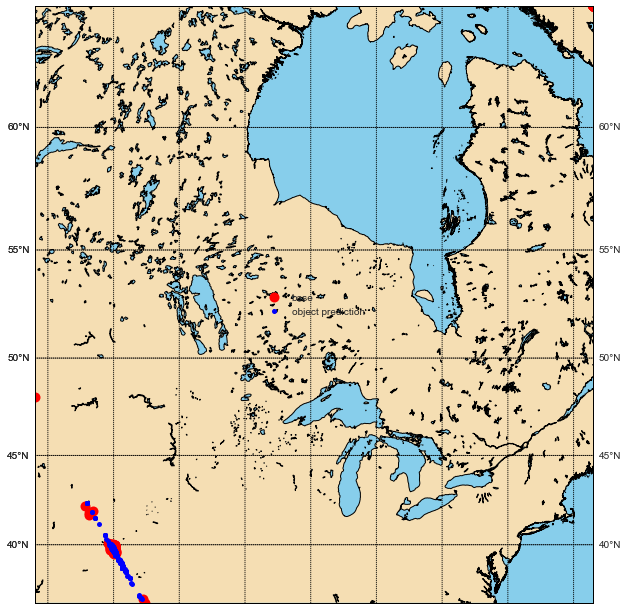

In [207]:
lng_bs = np.array(df_mess_test.groupby('bsid').first().bs_lng)
lat_bs = np.array(df_mess_test.groupby('bsid').first().bs_lat)

lng_obj = np.array(y_pred_lng)
lat_obj = np.array(y_pred_lat)

plt.figure(figsize=(10,20))

m = Basemap(projection='merc', lat_0 = 57, lon_0 = -135,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=np.min(lng_bs), llcrnrlat=np.min(lat_bs),
    urcrnrlon=np.max(lng_bs), urcrnrlat=np.max(lat_bs))
 
m.drawcoastlines()
m.drawparallels(np.arange(10,90,5),labels=[1,1,1,1])
m.drawparallels(range(30, 70, 5),labels=[1,0,0,1])
m.drawmeridians(np.arange(-110,-60,5),labels=[1,0,0,0])
m.fillcontinents(color='wheat',lake_color='skyblue')
m.drawmapboundary(fill_color='skyblue')
#m.fillcontinents()

x,y = m(lng_bs, lat_bs)
m.plot(x, y, 'bo', markersize=10,color='r', label='base')
x,y = m(lng_obj, lat_obj)
m.plot(x, y, 'bo', markersize=5,color='b', label='object prediction')
plt.legend()
plt.show()

In [200]:
test_res = pd.DataFrame(np.array(
    [testobjid.values, y_pred_lat, y_pred_lng]).T, columns=['objid', 'lat', 'lng'])

In [201]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [202]:
test_res.head()

,objid,lat,lng
0,573be2503e952e191262c351,39.7075,-105.044
1,573c05f83e952e1912758013,39.777,-105.009
2,573c0796f0fe6e735a66deb3,39.5236,-104.86
3,573c08d2864fce1a9a0563bc,39.8716,-105.051
4,573c08ff864fce1a9a0579b0,39.5236,-104.86
